<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Slice-specified-nodes-in-dimspec" data-toc-modified-id="Slice-specified-nodes-in-dimspec-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Slice specified nodes in dimspec</a></span></li><li><span><a href="#Test-parallelism" data-toc-modified-id="Test-parallelism-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Test parallelism</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Example-task" data-toc-modified-id="Example-task-2.0.1"><span class="toc-item-num">2.0.1&nbsp;&nbsp;</span>Example task</a></span></li></ul></li><li><span><a href="#Serial-invocation" data-toc-modified-id="Serial-invocation-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Serial invocation</a></span><ul class="toc-item"><li><span><a href="#Many-var-parallelisation" data-toc-modified-id="Many-var-parallelisation-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Many var parallelisation</a></span></li></ul></li><li><span><a href="#Plot-parallelisation-theoretical-speedup" data-toc-modified-id="Plot-parallelisation-theoretical-speedup-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Plot parallelisation theoretical speedup</a></span></li><li><span><a href="#Use-unix-tools" data-toc-modified-id="Use-unix-tools-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Use unix tools</a></span><ul class="toc-item"><li><span><a href="#Threading" data-toc-modified-id="Threading-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Threading</a></span></li><li><span><a href="#Multiprocessing" data-toc-modified-id="Multiprocessing-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Multiprocessing</a></span></li></ul></li></ul></li></ul></div>

In [20]:
import ray
import pyrofiler as pyrof
from pyrofiler.pyrofiler import Profiler
from pyrofiler import callbacks
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
sns.set_style('whitegrid')
np.random.seed(42)

# Slice specified nodes in dimspec

In [ ]:
def _none_slice():
    return slice(None)

def _get_idx(x, idxs, slice_idx, shapes=None):
    if shapes is None:
        shapes = [2]*len(idxs)
    point = np.unravel_index(slice_idx, shapes)
    get_point = {i:p for i,p in zip(idxs, point)}
    if x in idxs:
        p = get_point[x]
        return slice(p,p+1)
    else:
        return _none_slice()

def _slices_for_idxs(idxs, *args, shapes=None, slice_idx=0):
    """Return array of slices along idxs"""
    slices = []
    for indexes in args:
        _slice = [_get_idx(x, idxs, slice_idx, shapes) for x in indexes ]
        slices.append(tuple(_slice))
    return slices
        

In [27]:
def log_log_scale():
    plt.yscale('log')
    plt.xscale('log')
    
def minorticks():
    plt.minorticks_on()
    plt.grid(which='minor', alpha=0.5, linestyle='-', axis='both')

# Test parallelism
### Example task

In [58]:
def get_example_task(A=8, B=10, C=7):
    shape1 = [2]*(A+B)
    shape2 = [2]*(A+C)
    T1 = np.random.randn(*shape1)
    T2 = np.random.randn(*shape2)
    common = list(range(A))
    idxs1 = common + list(range(A, A+B))
    idxs2 = common + list(range(A+B, A+B+C))
    return (T1, idxs1), (T2, idxs2)

x, y = get_example_task()
x[1], y[1]

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 [0, 1, 2, 3, 4, 5, 6, 7, 18, 19, 20, 21, 22, 23, 24])

## Serial invocation

In [7]:
def contract(A, B):
    a, idxa = A
    b, idxb = B
    contract_idx = set(idxa) & set(idxb)
    result_idx = set(idxa + idxb)
    C = np.einsum(a,idxa, b,idxb, result_idx)
    return C

def sliced_contract(x, y, idxs, num):
    slices = _slices_for_idxs(idxs, x[1], y[1], slice_idx=num)
    a = x[0][slices[0]]
    b = y[0][slices[1]]
    with pyrof.timing(f'\tcontract sliced {num}'):
        C = contract((a, x[1]), (b, y[1]))
    return C

def target_slice(result_idx, idxs, num):
    slices = _slices_for_idxs(idxs, result_idx, slice_idx=num)
    return slices


with pyrof.timing('contract'):
    C = contract(x, y)


contract : 0.1349177360534668


### Many var parallelisation

In [77]:
prof_seq = Profiler()
prof_seq.use_append()

contract_idx = set(x[1]) & set(y[1])
result_idx = set(x[1] + y[1])

for i in range(3):
    _ = contract(x,y)
for rank in range(1,7):
    with prof_seq.timing('Single thread'):
        C = contract(x,y)
    
    par_vars = list(range(rank))
    target_shape = C.shape

    with prof_seq.timing('One patch: total'):
        i = 0
        with prof_seq.timing('One patch: compute'):
            patch = sliced_contract(x, y, par_vars, i)
        C_par = np.empty(target_shape)
        with prof_seq.timing('One patch: assign'):
            _slice = target_slice(result_idx, par_vars, i)
            C_par[_slice[0]] = patch


Single thread : 1.0604753494262695
	contract sliced 0 : 0.19724249839782715
One patch: compute : 0.20175814628601074
One patch: assign : 0.2649416923522949
One patch: total : 0.46805763244628906
Single thread : 40.41909599304199
	contract sliced 0 : 0.2914571762084961
One patch: compute : 0.3025023937225342
One patch: assign : 0.11948823928833008
One patch: total : 0.4281632900238037
Single thread : 0.5311300754547119
	contract sliced 0 : 0.13833212852478027
One patch: compute : 0.14123892784118652
One patch: assign : 0.10029149055480957
One patch: total : 0.24464917182922363
Single thread : 0.782768964767456
	contract sliced 0 : 0.023762226104736328
One patch: compute : 0.0253293514251709
One patch: assign : 0.023586034774780273
One patch: total : 0.0499567985534668
Single thread : 0.4178018569946289
	contract sliced 0 : 0.01177835464477539
One patch: compute : 0.014770030975341797
One patch: assign : 0.01289820671081543
One patch: total : 0.028556108474731445
Single thread : 0.374820

## Plot parallelisation theoretical speedup

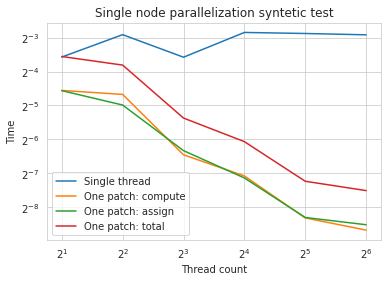

In [43]:
prof_seq.data
threads = 2**np.arange(1,7)

for k in prof_seq.data:
    plt.plot(threads, prof_seq.data[k], label=k)
    
plt.loglog(basex=2, basey=2)
from matplotlib.ticker import FormatStrFormatter

plt.title('Single node parallelization syntetic test')
plt.xlabel('Thread count')
plt.ylabel('Time')
minorticks()
plt.legend()
plt.savefig('figures/node_par_seqtest.pdf')

## Use unix tools
### Threading

In [46]:
from multiprocessing import Pool, Array
from multiprocessing.dummy import Pool as ThreadPool
import os

def tonumpyarray(mp_arr):
    return np.frombuffer(mp_arr.get_obj())

In [72]:
x,y = get_example_task(A=9, B=11, C=7)
contract_idx = set(x[1]) & set(y[1])
result_idx = set(x[1] + y[1])

In [73]:
prof_thread = Profiler()
prof_thread.use_append()



In [74]:
    
C_size = sys.getsizeof(C)
target_shape = C.shape

for i in range(3):
    _ = contract(x,y)
    
pool = ThreadPool(processes=2**7)
    
for rank in range(1,7):
    with prof_thread.timing('Single thread'):
        C = contract(x,y)

    with prof_thread.timing('Multithread: total'):
        par_vars = list(range(rank))
        threads = 2**len(par_vars)

        os.global_C = np.empty(target_shape)

        def work(i):
            patch = sliced_contract(x, y, par_vars, i)
            sl = target_slice(result_idx, par_vars, i)
            os.global_C[sl[0]] = patch

        with prof_thread.timing('Multithread: work'):
            _ = pool.map(work, range(threads))
            

Single thread : 0.5260138511657715
	contract sliced 1 : 0.5626978874206543
	contract sliced 0 : 0.6125516891479492
Multithread: work : 17.892274379730225
Multithread: total : 18.50485610961914
Single thread : 0.5576422214508057
	contract sliced 0	contract sliced 3	contract sliced 1	contract sliced 2 : 0.6045629978179932
  : 0.6012313365936279
: : 0.6742134094238281
 0.6062586307525635
Multithread: work : 1.7085037231445312
Multithread: total : 1.7473969459533691
Single thread : 0.3875846862792969
	contract sliced 0 : 0.0898747444152832
	contract sliced 4 : 0.32690930366516113
	contract sliced 1 : 0.6240272521972656
	contract sliced 7 : 0.5629255771636963
	contract sliced 2	contract sliced 3 : 0.6542999744415283
 : 0.6276445388793945
	contract sliced 6 : 0.6645774841308594
	contract sliced 5 : 0.8740389347076416
Multithread: work : 1.1029202938079834
Multithread: total : 1.1128926277160645
Single thread : 0.646895170211792
	contract sliced 0 	contract sliced 1 : 0.1600797176361084
: 0.1

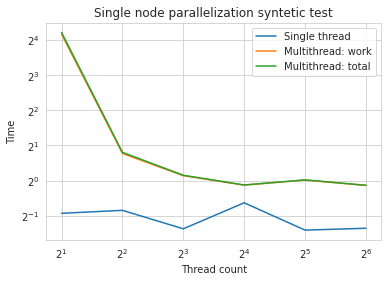

In [76]:
prof_seq.data
_data = prof_thread.data
threads = 2**np.arange(1,7)

for k in _data:
    plt.plot(threads, _data[k], label=k)
    
plt.loglog(basex=2, basey=2)
from matplotlib.ticker import FormatStrFormatter

plt.title('Single node parallelization syntetic test')
plt.xlabel('Thread count')
plt.ylabel('Time')
minorticks()
plt.legend()
plt.savefig('figures/node_par_threadtest.pdf')

###  Multiprocessing

In [ ]:

flat_size = len(C.flatten())
with pyrof.timing('init array'):
    os.global_C = np.empty(target_shape)
    #os.global_C = tonumpyarray(Array('d', flat_size))
#us.global_C = os.global_C.reshape(target_shape)

pool = Pool(processes=threads)
print('inited pool')
with pyrof.timing('parallel work'):
    print('started work')
    _ = pool.map(work, range(threads))

C_size = sys.getsizeof(os.global_C)
print(f'result size: {C_size:e}')
assert np.array_equal(C, os.global_C)


In [ ]:
del os.global_C